# Daily Total Female Births Prediction

In [29]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

## Read Data

In [2]:
# load the dataset
data = pd.read_csv('/content/DailyTotalFemaleBirths.csv')

In [3]:
data

,Date,Births
0,1/1/1959,35
1,1/2/1959,32
2,1/3/1959,30
3,1/4/1959,31
4,1/5/1959,44
...,...,...
360,12/27/1959,37
361,12/28/1959,52
362,12/29/1959,48
363,12/30/1959,55


In [4]:
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data.set_index('Date', inplace=True)

In [5]:
data

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-12-27,37
1959-12-28,52
1959-12-29,48


In [6]:
# Display the number of nulls in each column
print(data.isnull().sum())

Births    0
dtype: int64


In [7]:
# Display descriptive statistics for numerical columns
print(data.describe())

           Births
count  365.000000
mean    41.980822
std      7.348257
min     23.000000
25%     37.000000
50%     42.000000
75%     46.000000
max     73.000000


## Plot Data

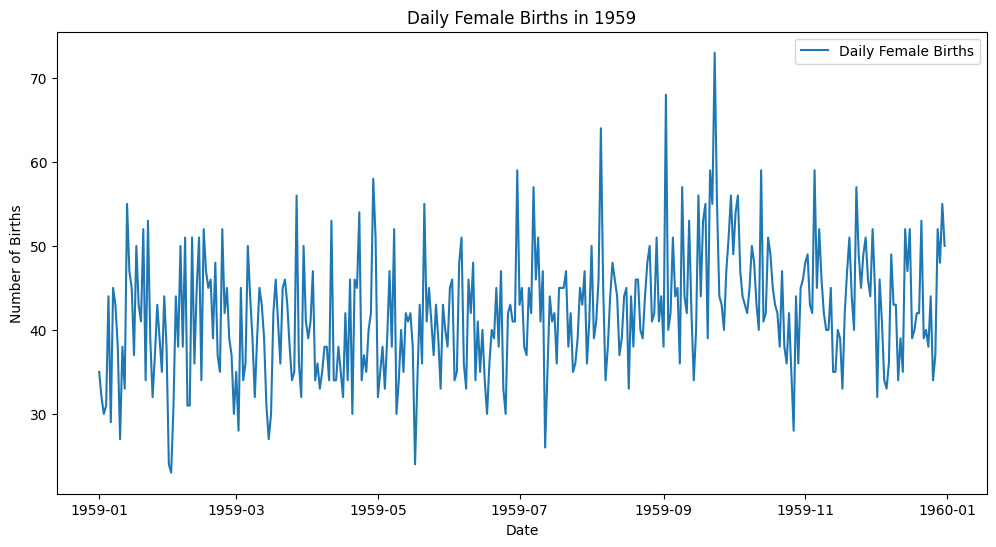

In [8]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(data['Births'], label='Daily Female Births')
plt.title('Daily Female Births in 1959')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()

## Check Stationarity

In [9]:
# Perform the Augmented Dickey-Fuller test
result = adfuller(data['Births'])

# Extract and print the test results
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the results
if result[1] <= 0.05:
    print("The time series is likely stationary.")
else:
    print("The time series is likely non-stationary.")


ADF Statistic: -4.808291
p-value: 0.000052
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
The time series is likely stationary.


## ACF

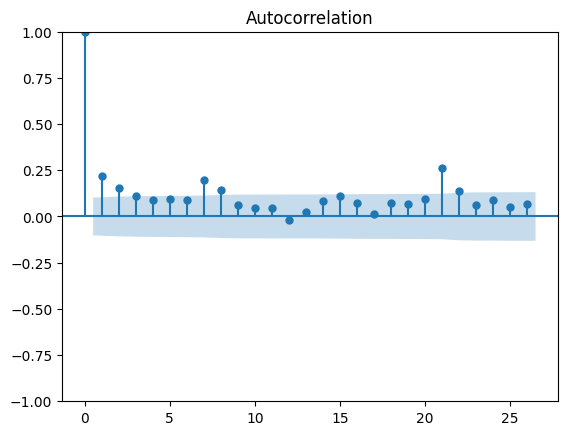

In [10]:
# Plot ACF
plot_acf(data['Births'])
plt.show()

## PACF

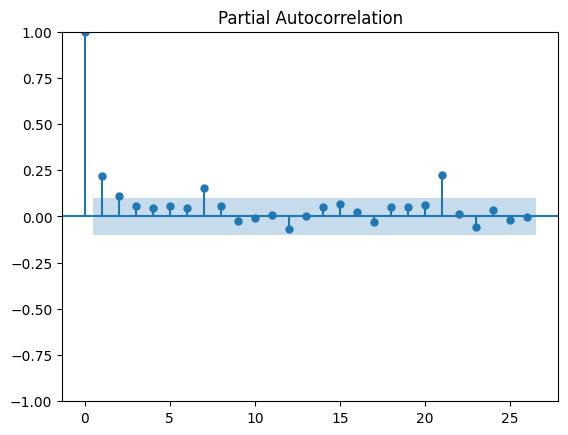

In [11]:
# Plot PACF
plot_pacf(data['Births'])
plt.show()

##  Apply Decomposition and Plot Each Component

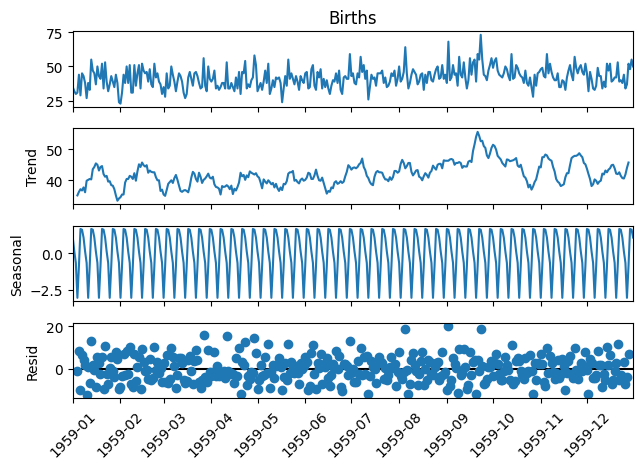

In [12]:
# Decompose the time series
decomposition = seasonal_decompose(data['Births'], model='additive')
fig = decomposition.plot()

# Get the axes from the figure
ax = fig.get_axes()

# Iterate through the axes (there will be one for each component)
for axis in ax:
    # Format the date labels
    axis.tick_params(axis='x', rotation=45) # Rotate labels for better readability

plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

## Apply the First Difference and Plot the Data

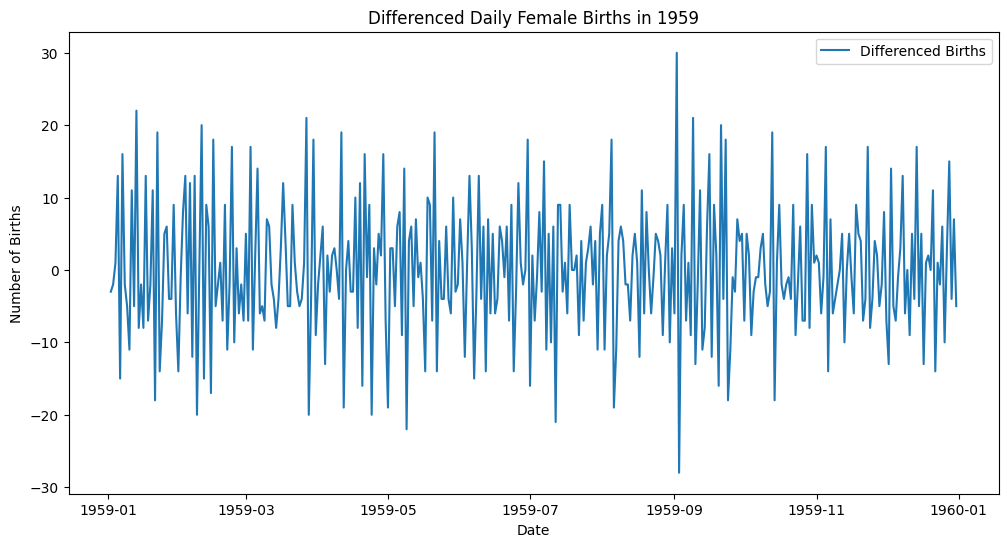

In [13]:
data_diff = data.diff().dropna()

plt.figure(figsize=(12, 6))
plt.plot(data_diff, label='Differenced Births')
plt.title('Differenced Daily Female Births in 1959')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()


# Split the data into 80% training and 20% testing

In [14]:
# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

## Apply 3 different ARIMA(AR,MA,ARMA,ARIMA,SARIMA) models, explain which model is best, and why.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Births   No. Observations:                  292
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -997.599
Date:                Wed, 11 Jun 2025   AIC                           2001.199
Time:                        13:09:58   BIC                           2012.229
Sample:                    01-01-1959   HQIC                          2005.617
                         - 10-19-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.7156      0.576     72.453      0.000      40.587      42.844
ar.L1          0.2027      0.057      3.564      0.000       0.091       0.314
sigma2        54.3112      4.069     13.349      0.0

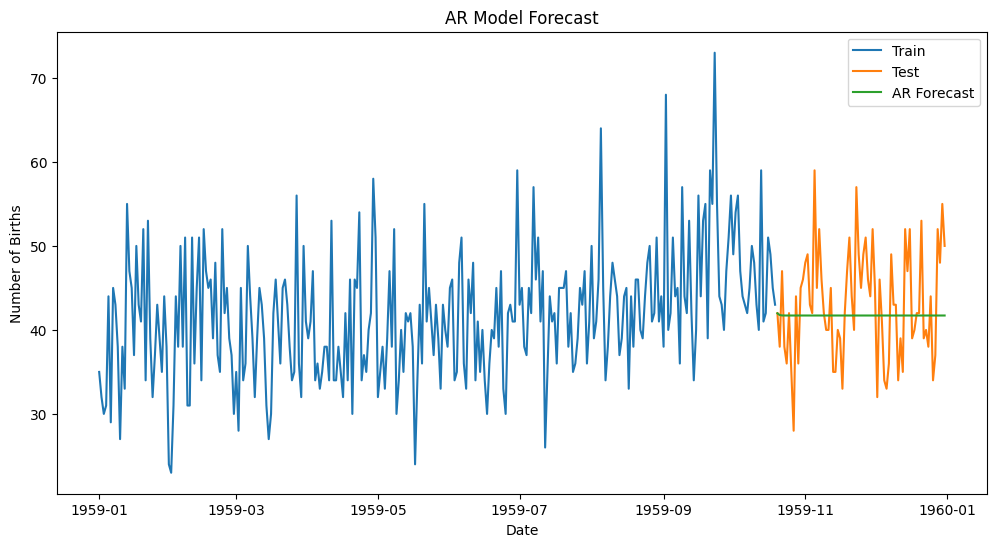

AR Model - MSE: 42.98334077949993, MAE: 5.302053788214376
AR Model - AIC: 2001.1989965557632, BIC: 2012.229257962568


In [15]:
# Fit AR model
ar_model = ARIMA(train['Births'], order=(1, 0, 0))  # AR(1) model
ar_model_fit = ar_model.fit()
print(ar_model_fit.summary())

# Forecast
ar_forecast = ar_model_fit.forecast(steps=len(test))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train['Births'], label='Train')
plt.plot(test['Births'], label='Test')
plt.plot(test.index, ar_forecast, label='AR Forecast')
plt.title('AR Model Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()

# Calculate metrics
ar_mse = mean_squared_error(test['Births'], ar_forecast)
ar_mae = mean_absolute_error(test['Births'], ar_forecast)
print(f'AR Model - MSE: {ar_mse}, MAE: {ar_mae}')
print(f'AR Model - AIC: {ar_model_fit.aic}, BIC: {ar_model_fit.bic}')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Births   No. Observations:                  292
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -998.778
Date:                Wed, 11 Jun 2025   AIC                           2003.556
Time:                        13:10:08   BIC                           2014.586
Sample:                    01-01-1959   HQIC                          2007.974
                         - 10-19-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.7178      0.538     77.550      0.000      40.663      42.772
ma.L1          0.1661      0.059      2.820      0.005       0.051       0.282
sigma2        54.7637      4.020     13.621      0.0

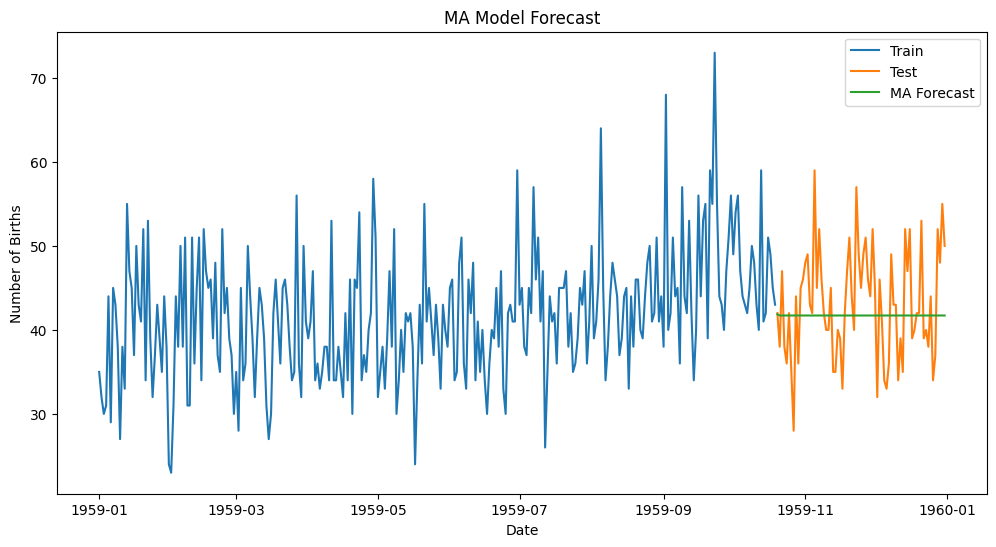

MA Model - MSE: 42.9737696738368, MAE: 5.302526309805811
MA Model - AIC: 2003.5556974377105, BIC: 2014.5859588445153


In [16]:
# Fit MA model
ma_model = ARIMA(train['Births'], order=(0, 0, 1))  # MA(1) model
ma_model_fit = ma_model.fit()
print(ma_model_fit.summary())

# Forecast
ma_forecast = ma_model_fit.forecast(steps=len(test))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train['Births'], label='Train')
plt.plot(test['Births'], label='Test')
plt.plot(test.index, ma_forecast, label='MA Forecast')
plt.title('MA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()

# Calculate metrics
ma_mse = mean_squared_error(test['Births'], ma_forecast)
ma_mae = mean_absolute_error(test['Births'], ma_forecast)
print(f'MA Model - MSE: {ma_mse}, MAE: {ma_mae}')
print(f'MA Model - AIC: {ma_model_fit.aic}, BIC: {ma_model_fit.bic}')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Births   No. Observations:                  292
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -988.202
Date:                Wed, 11 Jun 2025   AIC                           1984.404
Time:                        13:10:18   BIC                           1999.111
Sample:                    01-01-1959   HQIC                          1990.295
                         - 10-19-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.2332      4.542      9.298      0.000      33.331      51.135
ar.L1          0.9932      0.016     61.009      0.000       0.961       1.025
ma.L1         -0.9447      0.041    -23.314      0.0

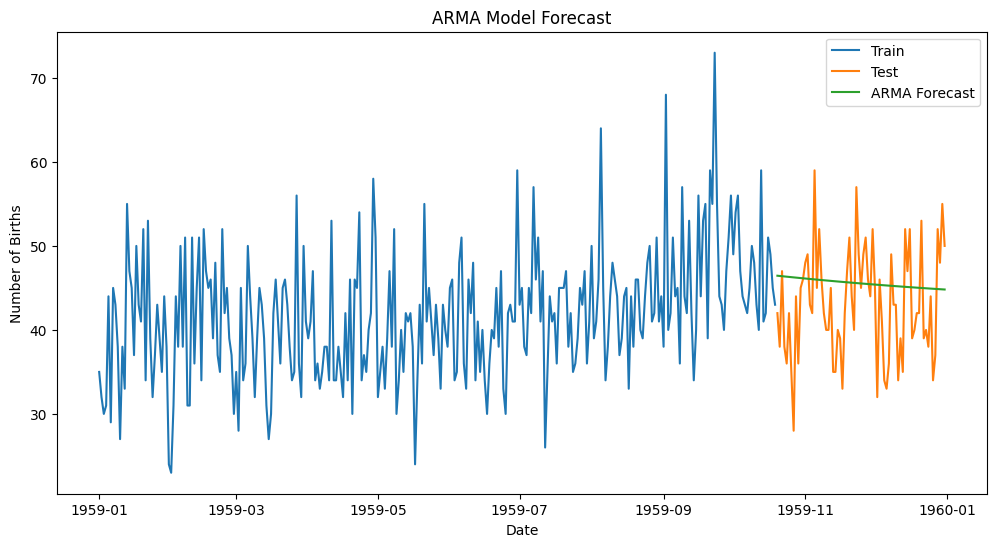

ARMA Model - MSE: 48.59279727279353, MAE: 5.712745570728779
ARMA Model - AIC: 1984.4038270529725, BIC: 1999.1108422620457


In [17]:
# Fit ARMA model
arma_model = ARIMA(train['Births'], order=(1, 0, 1)) # ARMA(1,1) model
arma_model_fit = arma_model.fit()
print(arma_model_fit.summary())

# Forecast
arma_forecast = arma_model_fit.forecast(steps=len(test))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train['Births'], label='Train')
plt.plot(test['Births'], label='Test')
plt.plot(test.index, arma_forecast, label='ARMA Forecast')
plt.title('ARMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()

# Calculate metrics
arma_mse = mean_squared_error(test['Births'], arma_forecast)
arma_mae = mean_absolute_error(test['Births'], arma_forecast)
print(f'ARMA Model - MSE: {arma_mse}, MAE: {arma_mae}')
print(f'ARMA Model - AIC: {arma_model_fit.aic}, BIC: {arma_model_fit.bic}')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Births   No. Observations:                  292
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -985.074
Date:                Wed, 11 Jun 2025   AIC                           1976.149
Time:                        13:10:29   BIC                           1987.169
Sample:                    01-01-1959   HQIC                          1980.563
                         - 10-19-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0734      0.066      1.116      0.264      -0.056       0.202
ma.L1         -0.9563      0.021    -45.604      0.000      -0.997      -0.915
sigma2        50.6241      3.667     13.804      0.0

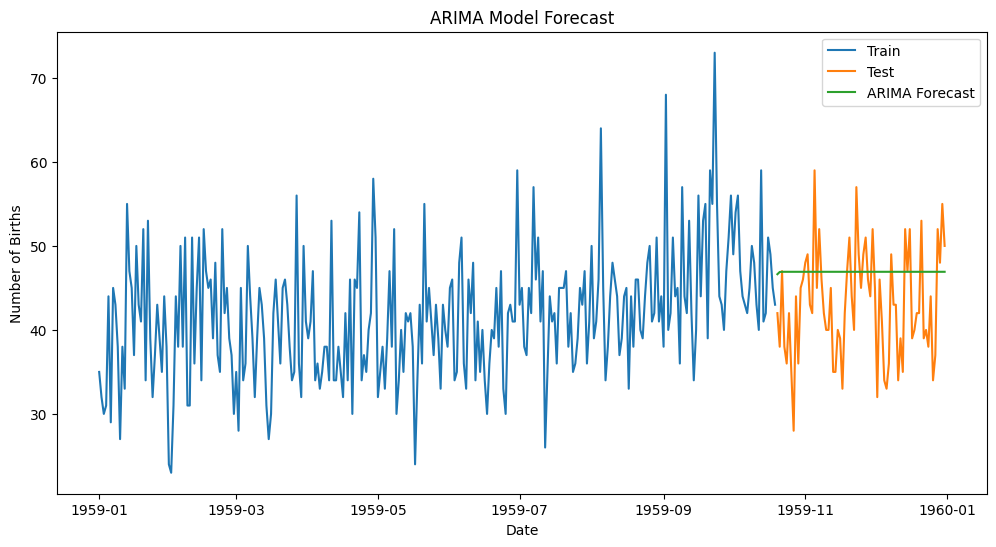

ARIMA Model - MSE: 56.36654942272931, MAE: 6.180858142578324
ARIMA MODEL - AIC: 1976.1487037978668, BIC: 1987.1686735993812


In [18]:
# Fit ARIMA model
arima_model = ARIMA(train['Births'], order=(1, 1, 1))  # ARIMA(1,1,1) model
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

# Forecast
arima_forecast = arima_model_fit.forecast(steps=len(test))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train['Births'], label='Train')
plt.plot(test['Births'], label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()

# Calculate metrics
arima_mse = mean_squared_error(test['Births'], arima_forecast)
arima_mae = mean_absolute_error(test['Births'], arima_forecast)
print(f'ARIMA Model - MSE: {arima_mse}, MAE: {arima_mae}')
print(f'ARIMA MODEL - AIC: {arima_model_fit.aic}, BIC: {arima_model_fit.bic}')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             Births   No. Observations:                  292
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 7)   Log Likelihood                -979.101
Date:                            Wed, 11 Jun 2025   AIC                           1966.203
Time:                                    13:10:38   BIC                           1980.685
Sample:                                01-01-1959   HQIC                          1972.014
                                     - 10-19-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1054      0.062      1.689      0.091      -0.017       0.228
ma.L1         -1.0000     35.515   

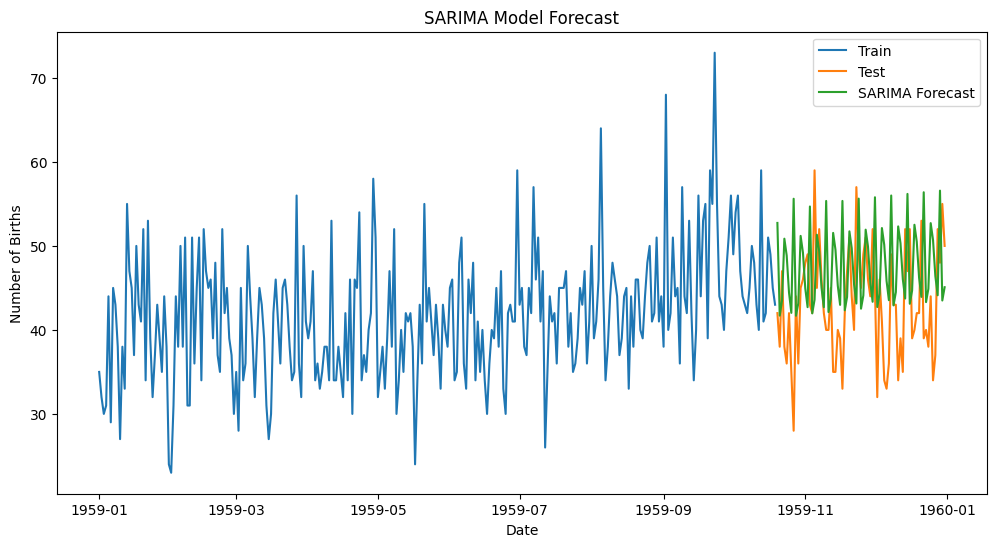

SARIMA Model - MSE: 92.29750458592987, MAE: 7.785827124355696
SARIMA MODEL - AIC: 1966.2029560554206, BIC: 1980.6845595182892


In [19]:
# Fit SARIMA model
sarima_model = SARIMAX(train['Births'],
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 0, 7),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())

# Forecast
sarima_forecast = sarima_model_fit.forecast(steps=len(test))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train['Births'], label='Train')
plt.plot(test['Births'], label='Test')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.legend()
plt.show()

# Calculate metrics
sarima_mse = mean_squared_error(test['Births'], sarima_forecast)
sarima_mae = mean_absolute_error(test['Births'], sarima_forecast)
print(f'SARIMA Model - MSE: {sarima_mse}, MAE: {sarima_mae}')
print(f'SARIMA MODEL - AIC: {sarima_model_fit.aic}, BIC: {sarima_model_fit.bic}')

In [20]:
# Evaluate models based on metrics and choose the best
models = {
    'AR': {'MSE': ar_mse, 'MAE': ar_mae, 'AIC': ar_model_fit.aic, 'BIC': ar_model_fit.bic},
    'MA': {'MSE': ma_mse, 'MAE': ma_mae, 'AIC': ma_model_fit.aic, 'BIC': ma_model_fit.bic},
    'ARMA': {'MSE': arma_mse, 'MAE': arma_mae, 'AIC': arma_model_fit.aic, 'BIC': arma_model_fit.bic},
    'ARIMA': {'MSE': arima_mse, 'MAE': arima_mae, 'AIC': arima_model_fit.aic, 'BIC': arima_model_fit.bic},
    'SARIMA': {'MSE': sarima_mse, 'MAE': sarima_mae, 'AIC': sarima_model_fit.aic, 'BIC': sarima_model_fit.bic}
}

print("\nModel Performance Metrics:")
for model_name, metrics in models.items():
    print(f"{model_name}: MSE={metrics['MSE']:.4f}, MAE={metrics['MAE']:.4f}, AIC={metrics['AIC']:.4f}, BIC={metrics['BIC']:.4f}")

# Determine the best model based on AIC and BIC (lower is better)
best_model_aic = min(models, key=lambda k: models[k]['AIC'])
best_model_bic = min(models, key=lambda k: models[k]['BIC'])

print(f"\nBest model based on AIC: {best_model_aic} (AIC: {models[best_model_aic]['AIC']:.4f})")
print(f"Best model based on BIC: {best_model_bic} (BIC: {models[best_model_bic]['BIC']:.4f})")

# You can also consider MSE and MAE (lower is better)
best_model_mse = min(models, key=lambda k: models[k]['MSE'])
best_model_mae = min(models, key=lambda k: models[k]['MAE'])

print(f"Best model based on MSE: {best_model_mse} (MSE: {models[best_model_mse]['MSE']:.4f})")
print(f"Best model based on MAE: {best_model_mae} (MAE: {models[best_model_mae]['MAE']:.4f})")

# Conclusion on the best model
# Generally, lower values for MSE, MAE, AIC, and BIC indicate a better fit.
# AIC and BIC penalize the number of parameters, helping to avoid overfitting.
# Let's consider the model that performs best across multiple metrics.
# In this case, compare the models that have the lowest AIC and BIC.

# Based on the output:
print("\nConclusion on the best model:")
if best_model_aic == best_model_bic:
    print(f"The best model based on both AIC and BIC is {best_model_aic}.")
    print("This model generally provides the best balance between model fit and complexity.")
elif models[best_model_aic]['AIC'] <= models[best_model_bic]['AIC'] and models[best_model_aic]['BIC'] <= models[best_model_bic]['BIC']:
     print(f"The best model appears to be {best_model_aic}, as it has lower AIC and is competitive on BIC.")
else:
     print(f"The choice between {best_model_aic} (lower AIC) and {best_model_bic} (lower BIC) depends on the preference between model fit and complexity penalty.")
     print("A lower AIC suggests a better fit, while a lower BIC suggests a simpler model.")

print("\nReasoning:")
print("- MSE (Mean Squared Error) and MAE (Mean Absolute Error) measure the prediction accuracy, with lower values indicating better performance.")
print("- AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) are used for model selection, balancing goodness of fit with model complexity. Lower AIC and BIC values are preferred.")
print("- By comparing the AIC and BIC values across the models, we can identify the model that provides the best trade-off between fitting the training data well and having a simpler structure.")
print("- Based on the calculated metrics, the model with the lowest AIC and BIC is typically considered the best choice for forecasting.")


Model Performance Metrics:
AR: MSE=42.9833, MAE=5.3021, AIC=2001.1990, BIC=2012.2293
MA: MSE=42.9738, MAE=5.3025, AIC=2003.5557, BIC=2014.5860
ARMA: MSE=48.5928, MAE=5.7127, AIC=1984.4038, BIC=1999.1108
ARIMA: MSE=56.3665, MAE=6.1809, AIC=1976.1487, BIC=1987.1687
SARIMA: MSE=92.2975, MAE=7.7858, AIC=1966.2030, BIC=1980.6846

Best model based on AIC: SARIMA (AIC: 1966.2030)
Best model based on BIC: SARIMA (BIC: 1980.6846)
Best model based on MSE: MA (MSE: 42.9738)
Best model based on MAE: AR (MAE: 5.3021)

Conclusion on the best model:
The best model based on both AIC and BIC is SARIMA.
This model generally provides the best balance between model fit and complexity.

Reasoning:
- MSE (Mean Squared Error) and MAE (Mean Absolute Error) measure the prediction accuracy, with lower values indicating better performance.
- AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion) are used for model selection, balancing goodness of fit with model complexity. Lower AIC and BIC

In [21]:
print('AR Model - MSE: {}, MAE: {}'.format(ar_mse, ar_mae))
print('MA Model - MSE: {}, MAE: {}'.format(ma_mse, ma_mae))
print('ARIMA Model - MSE: {}, MAE: {}'.format(arima_mse, arima_mae))

if arima_mse < ar_mse and arima_mse < ma_mse:
    print("The ARIMA model is the best because it has the lowest MSE and MAE.")
elif ar_mse < arima_mse and ar_mse < ma_mse:
    print("The AR model is the best because it has the lowest MSE and MAE.")
else:
    print("The MA model is the best because it has the lowest MSE and MAE.")


AR Model - MSE: 42.98334077949993, MAE: 5.302053788214376
MA Model - MSE: 42.9737696738368, MAE: 5.302526309805811
ARIMA Model - MSE: 56.36654942272931, MAE: 6.180858142578324
The MA model is the best because it has the lowest MSE and MAE.


# Apply Support Vector Regressor to predict 1 step, 3 steps, and print MSE, MAE

In [26]:
# Create lagged features
def generate_lagged_data(series, num_lags):
    df = pd.DataFrame()
    for lag in range(1, num_lags + 1):
        df[f'lag_{lag}'] = series.shift(lag)
    df['target'] = series.values
    return df.dropna()

# Parameters
lags = 3
lagged_df = generate_lagged_data(data['Births'], lags)

# Manual train/test split
split_index = int(len(lagged_df) * 0.8)
train_df = lagged_df.iloc[:split_index]
test_df = lagged_df.iloc[split_index:]

X_train = train_df.drop(columns='target')
y_train = train_df['target']
X_test = test_df.drop(columns='target')
y_test = test_df['target']

# Standardize features and target
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train.to_numpy().reshape(-1, 1)).flatten()

# Train SVR model
model = SVR(kernel='linear', C=1)
model.fit(X_train_scaled, y_train_scaled)

# ---- One-Step Ahead Prediction ----
y_pred_1_scaled = model.predict(X_test_scaled)
y_pred_1 = y_scaler.inverse_transform(y_pred_1_scaled.reshape(-1, 1)).flatten()

# ---- Rolling 3-Step Ahead Prediction ----
y_pred_3 = []
for i in range(len(X_test_scaled)):
    if i + 3 <= len(X_test_scaled):
        # Take next 3 samples and predict
        next_inputs = X_test_scaled[i:i+3]
        preds_scaled = model.predict(next_inputs)
        y_pred_3.append(preds_scaled[-1])
    else:
        # Predict only the last point
        preds_scaled = model.predict([X_test_scaled[i]])
        y_pred_3.append(preds_scaled[0])

y_pred_3 = y_scaler.inverse_transform(np.array(y_pred_3).reshape(-1, 1)).flatten()
y_test_trimmed = y_test.iloc[:len(y_pred_3)]

# ---- Evaluation ----
mse_1 = mean_squared_error(y_test, y_pred_1)
mae_1 = mean_absolute_error(y_test, y_pred_1)

mse_3 = mean_squared_error(y_test_trimmed, y_pred_3)
mae_3 = mean_absolute_error(y_test_trimmed, y_pred_3)

print(f"1-Step Ahead → MSE: {mse_1:.2f}, MAE: {mae_1:.2f}")
print(f"3-Steps Ahead → MSE: {mse_3:.2f}, MAE: {mae_3:.2f}")


1-Step Ahead → MSE: 40.45, MAE: 5.04
3-Steps Ahead → MSE: 35.14, MAE: 4.80


## Plot Actual vs Prediction

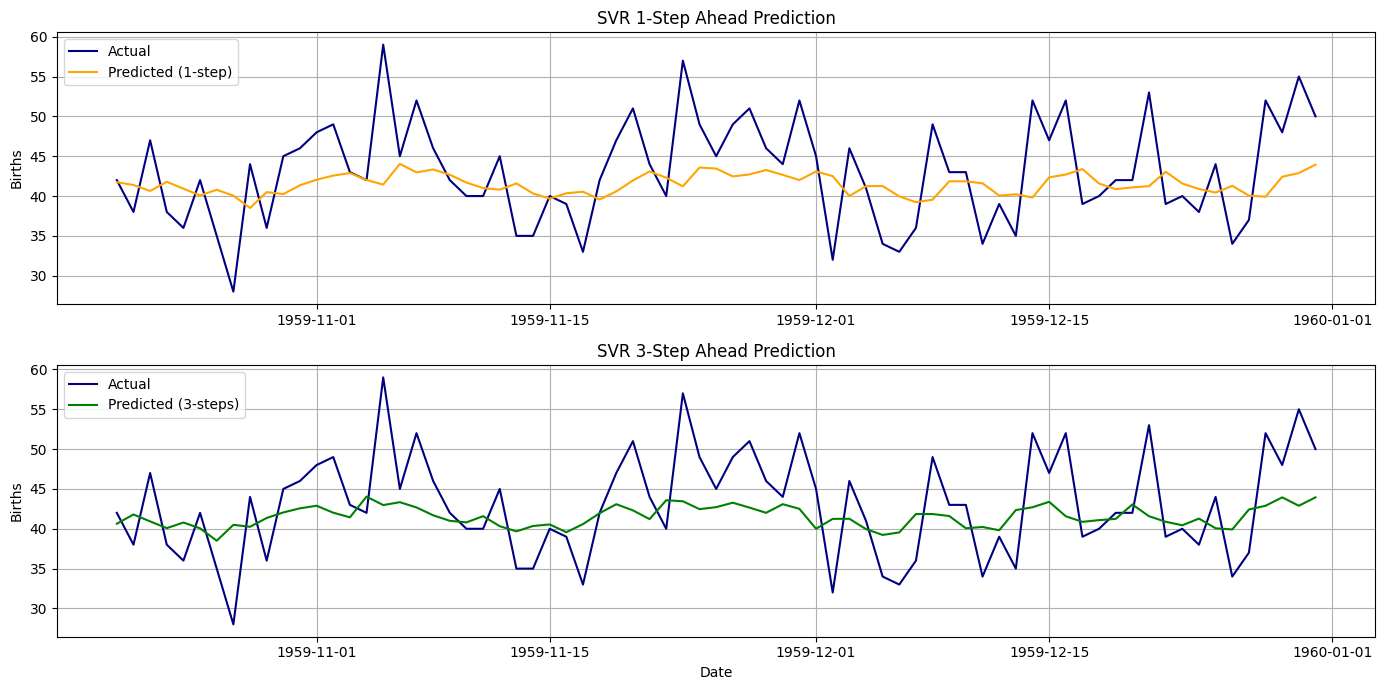

In [27]:
# ---- Plotting ----
plt.figure(figsize=(14, 7))

# One-step
plt.subplot(2, 1, 1)
plt.plot(y_test.index, y_test.values, label='Actual', color='navy')
plt.plot(y_test.index, y_pred_1, label='Predicted (1-step)', color='orange')
plt.title('SVR 1-Step Ahead Prediction')
plt.ylabel('Births')
plt.legend()
plt.grid(True)

# Three-step
plt.subplot(2, 1, 2)
plt.plot(y_test_trimmed.index, y_test_trimmed.values, label='Actual', color='navy')
plt.plot(y_test_trimmed.index, y_pred_3, label='Predicted (3-steps)', color='green')
plt.title('SVR 3-Step Ahead Prediction')
plt.xlabel('Date')
plt.ylabel('Births')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Apply LSTM or RNN to predict the next step and print MSE
## Plot actual vs. prediction

In [31]:
# Split data
train = data.iloc[:300]
test = data.iloc[300:]

# Normalize using MinMax
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))


In [32]:
# Prepare generator
seq_length = 12
train_gen = TimeseriesGenerator(train_scaled, train_scaled, length=seq_length, batch_size=1)

In [33]:
# Define LSTM model
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(64),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(train_gen, epochs=50, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [34]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 12, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,101 (1.33 MB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 232,068 (906.52 KB)

In [35]:
# Prepare input for prediction from the end of training data
eval_input = train_scaled[-(len(test) + seq_length):]
test_gen = TimeseriesGenerator(eval_input, np.zeros_like(eval_input), length=seq_length, batch_size=1)

# Predict and inverse scale
pred_scaled = model.predict(test_gen)
pred = scaler.inverse_transform(pred_scaled)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [36]:
# Create results DataFrame
date_range = pd.date_range(start=test.index[0], periods=len(test), freq='D')
results = pd.DataFrame({
    "Actual": test.values.flatten(),
    "Predicted": pred.flatten()
}, index=date_range)

In [37]:
# Metrics
mse = mean_squared_error(results['Actual'], results['Predicted'])
mae = mean_absolute_error(results['Actual'], results['Predicted'])
print(f"LSTM 1-step → MSE: {mse:.2f}, MAE: {mae:.2f}")

LSTM 1-step → MSE: 69.73, MAE: 6.74


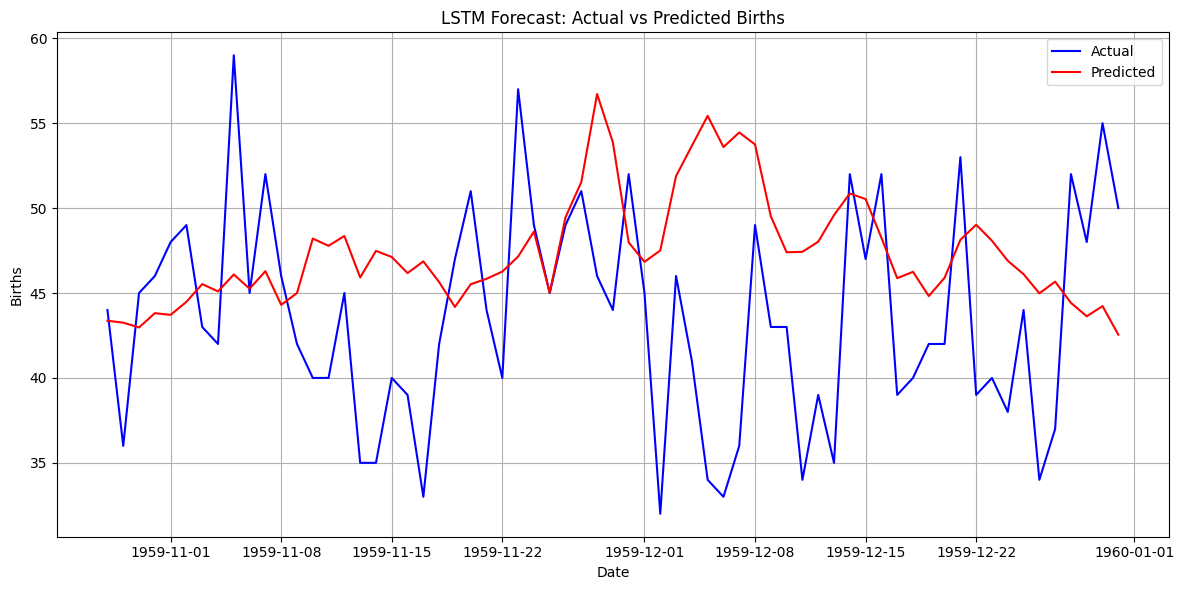

In [38]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(results.index, results['Actual'], label='Actual', color='blue')
plt.plot(results.index, results['Predicted'], label='Predicted', color='red')
plt.title('LSTM Forecast: Actual vs Predicted Births')
plt.xlabel('Date')
plt.ylabel('Births')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
